In [2]:
import requests

NEWS_API_KEY = "0ce5c6e52bb14440a6a4747173920518"  

def fetch_latest_news():
    url = f"https://newsapi.org/v2/top-headlines?language=en&apiKey={NEWS_API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        articles = response.json()["articles"]
        return [article["title"] + " " + article["description"] for article in articles if article["description"]]
    return []

latest_news = fetch_latest_news()
print(f"Fetched {len(latest_news)} latest news articles.")


Fetched 17 latest news articles.


In [5]:
import pandas as pd

# Load both datasets
df_fake = pd.read_csv(r"E:\code\project\fakenews\database\Fake.csv")
df_true = pd.read_csv(r"E:\code\project\fakenews\database\True.csv")

# Add labels (1 = Fake, 0 = Real)
df_fake["label"] = 1
df_true["label"] = 0

# Combine datasets
df = pd.concat([df_fake, df_true], axis=0)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display dataset structure
print(df.head())


                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      1  
1       April 5, 2017       0  
2  September 27, 2017       0  
3         May 22, 2017      1  
4       June 24, 2016       0  


In [6]:
import re
from sklearn.model_selection import train_test_split

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply preprocessing
df["clean_text"] = (df["title"] + " " + df["text"]).apply(preprocess_text)

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label"], test_size=0.2, random_state=42)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Convert text into numerical vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Naïve Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Evaluate Model
y_pred = nb_model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"Naïve Bayes Model Accuracy: {accuracy:.2f}")


Naïve Bayes Model Accuracy: 0.93


In [8]:
import joblib

joblib.dump(nb_model, "naive_bayes_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Convert text into sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=300)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=300)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Create CNN model
cnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=50, input_length=300),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(10, activation="relu"),
    Dense(1, activation="sigmoid")  # Output: 0 (Real) or 1 (Fake)
])

cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train CNN model
cnn_model.fit(X_train_seq, y_train, epochs=5, batch_size=32, validation_data=(X_test_seq, y_test))

# Save CNN Model
cnn_model.save("cnn_model.h5")
joblib.dump(tokenizer, "tokenizer.pkl")


Epoch 1/5


c:\Users\pathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.9294 - loss: 0.2021 - val_accuracy: 0.9893 - val_loss: 0.0318
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.9963 - loss: 0.0143 - val_accuracy: 0.9920 - val_loss: 0.0276
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.9909 - val_loss: 0.0315
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9932 - val_loss: 0.0269
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 1.0000 - loss: 2.8240e-04 - val_accuracy: 0.9918 - val_loss: 0.0346


['tokenizer.pkl']

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 1.0000 - loss: 1.2139e-06 - val_accuracy: 0.9944 - val_loss: 0.0419
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 1.0000 - loss: 8.1545e-07 - val_accuracy: 0.9944 - val_loss: 0.0429
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 1.0000 - loss: 4.8777e-07 - val_accuracy: 0.9940 - val_loss: 0.0441
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 1.0000 - loss: 2.8838e-07 - val_accuracy: 0.9944 - val_loss: 0.0451
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 1.0000 - loss: 1.7451e-07 - val_accuracy: 0.9942 - val_loss: 0.0463


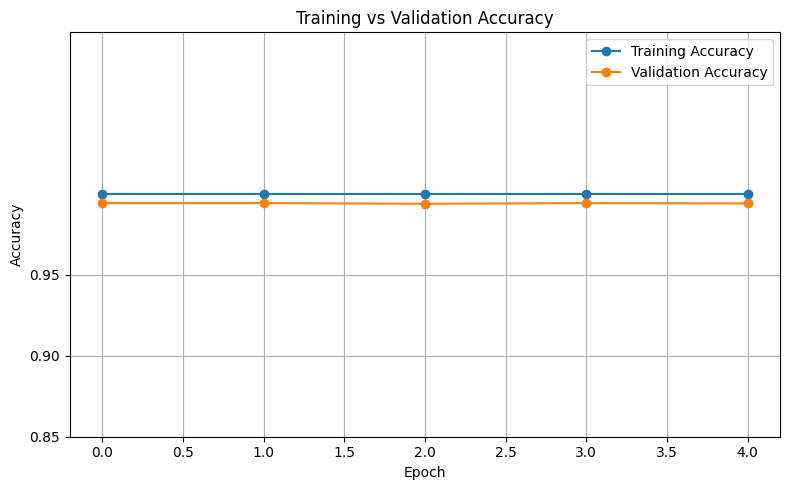

In [13]:
import matplotlib.pyplot as plt

# Store training history in a variable
history = cnn_model.fit(
    X_train_seq, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_seq, y_test)
)

# Plot Training vs Validation Accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.85, 1.10)
    plt.yticks([round(i, 2) for i in list(frange(0.85, 1.00, 0.05))])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Helper function for float range
def frange(start, stop, step):
    while start < stop:
        yield start
        start += step

plot_accuracy(history)


In [9]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'X_train' contains your training news articles (processed text)
vectorizer = TfidfVectorizer(max_features=5000)  # Set appropriate max features
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit on training data

# **Save the vectorizer**
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'")


TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import joblib

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM model
svm_model = SVC(probability=True, kernel="linear", random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Save the trained model and vectorizer
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("SVM model training complete and saved!")


SVM model training complete and saved!


In [11]:
# Load trained models
import numpy as np
from tensorflow.keras.models import load_model

naive_bayes_model = joblib.load("naive_bayes_model.pkl")  
cnn_model = load_model("cnn_model.h5")  
svm_model = joblib.load("svm_model.pkl")  
vectorizer = joblib.load("tfidf_vectorizer.pkl")
tokenizer = joblib.load("tokenizer.pkl")

def predict_news(text):
    processed_text = preprocess_text(text)

    # Naive Bayes Prediction
    text_tfidf = vectorizer.transform([processed_text])
    nb_real_prob = naive_bayes_model.predict_proba(text_tfidf)[0][0] * 100

    # CNN Prediction
    seq = tokenizer.texts_to_sequences([processed_text])
    padded_seq = pad_sequences(seq, maxlen=300)
    cnn_real_prob = (1 - cnn_model.predict(padded_seq)[0][0]) * 100

    # SVM Prediction
    svm_real_prob = svm_model.predict_proba(text_tfidf)[0][0] * 100

    # Weighted Voting (giving higher weight to CNN)
    final_real_prob = (0.2 * nb_real_prob) + (0.5 * cnn_real_prob) + (0.3 * svm_real_prob)

    # Round probabilities
    nb_real_prob = round(nb_real_prob, 2)
    cnn_real_prob = round(cnn_real_prob, 2)
    svm_real_prob = round(svm_real_prob, 2)
    final_real_prob = round(final_real_prob, 2)

    return {
        "naive_bayes": f"1️⃣ Naive Bayes: **{nb_real_prob}% real**",
        "cnn": f"2️⃣ CNN: **{cnn_real_prob}% real**",
        "svm": f"3️⃣ SVM: **{svm_real_prob}% real**",
        "final": f"🔥 Final Verdict: **{final_real_prob}% real**"
    }


In [12]:
from sklearn.model_selection import train_test_split

# Fetch latest news and create dataset dynamically
real_news = fetch_latest_news()  # Real news from API
fake_news = ["This is fake news article generated for training purposes."] * len(real_news)  # Placeholder fake news

# Combine and label data
X_data = real_news + fake_news
y_data = [1] * len(real_news) + [0] * len(fake_news)  # 1 for real, 0 for fake

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print("Dataset dynamically created from NewsAPI!")


Dataset dynamically created from NewsAPI!
